# How to Train YOLOv9 on a Custom Dataset
---

[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov9-model/)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/WongKinYiu/yolov9)
[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/XHT2c8jT3Bc)
[![arXiv](https://img.shields.io/badge/arXiv-2402.13616-b31b1b.svg)](https://arxiv.org/pdf/2402.13616.pdf)

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Mon Jun 23 04:37:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
!pip3 install --upgrade 'pillow<10'
!pip3 install --upgrade torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 41.9 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: pillow 11.2.1
    Uninstalling pillow-11.2.1:
      Successfully uninstalled pillow-11.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires pillow>=10.1, but you have pillow 9.5.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Clone and Install

**NOTE:** YOLOv9 is very new. At the moment, we recommend using a fork of the main repository. The `detect.py` script contains a bug that prevents inference. This bug is patched in the fork.

In [4]:
!git clone  https://github.com/WongKinYiu/yolov9.git
%cd yolov9
!pip install -r requirements.txt -q

Cloning into 'yolov9'...
remote: Enumerating objects: 781, done.
remote: Counting objects: 100% (316/316), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 781 (delta 265), reused 257 (delta 257), pack-reused 465 (from 1)
Receiving objects: 100% (781/781), 3.25 MiB | 7.13 MiB/s, done.
Resolving deltas: 100% (339/339), done.
/content/yolov9
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.9 MB/s eta 0:00:00


In [5]:
pwd

'/content/yolov9'

**NOTE:** Let's install the [`roboflow`](https://pypi.org/project/roboflow) package, which we will use to download our dataset from [Roboflow Universe](https://universe.roboflow.com/).

In [6]:
!pip install -q roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 113.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 112.3 MB/s eta 0:00:00


## Download model weights

**NOTE:** In the YOLOv9 paper, versions `yolov9-s` and `yolov9-m` are also mentioned, but the weights for these models are not yet available in the YOLOv9 [repository](https://github.com/WongKinYiu/yolov9).

In [7]:
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-e.pt

In [8]:
!ls -la {HOME}/weights

total 402456
drwxr-xr-x 2 root root      4096 Jun 23 04:41 .
drwxr-xr-x 1 root root      4096 Jun 23 04:41 ..
-rw-r--r-- 1 root root  51508261 Feb 18  2024 gelan-c.pt
-rw-r--r-- 1 root root 117203713 Feb 18  2024 gelan-e.pt
-rw-r--r-- 1 root root 103153312 Feb 18  2024 yolov9-c.pt
-rw-r--r-- 1 root root 140217688 Feb 18  2024 yolov9-e.pt


## Download example data

**NOTE:** If you want to run inference using your own file as input, simply upload image to Google Colab and update `SOURCE_IMAGE_PATH` with the path leading to your file.

In [9]:
!wget -P {HOME}/data -q https://media.roboflow.com/notebooks/examples/dog.jpeg

In [10]:
SOURCE_IMAGE_PATH = f"{HOME}/dog.jpeg"

## Detection with pre-trained COCO model

### gelan-c

In [11]:
!python detect.py --weights {HOME}/weights/gelan-c.pt --conf 0.1 --source {HOME}/data/dog.jpeg --device 0

detect: weights=['/content/weights/gelan-c.pt'], source=/content/data/dog.jpeg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLO 🚀 v0.1-104-g5b1ea9a Python-3.11.13 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)

/content/yolov9/models/experimental.py:243: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weig

**NOTE:** By default, the results of each subsequent inference sessions are saved in `{HOME}/yolov9/runs/detect/`, in directories named `exp`, `exp2`, `exp3`, ... You can override this behavior by using the `--name` parameter.

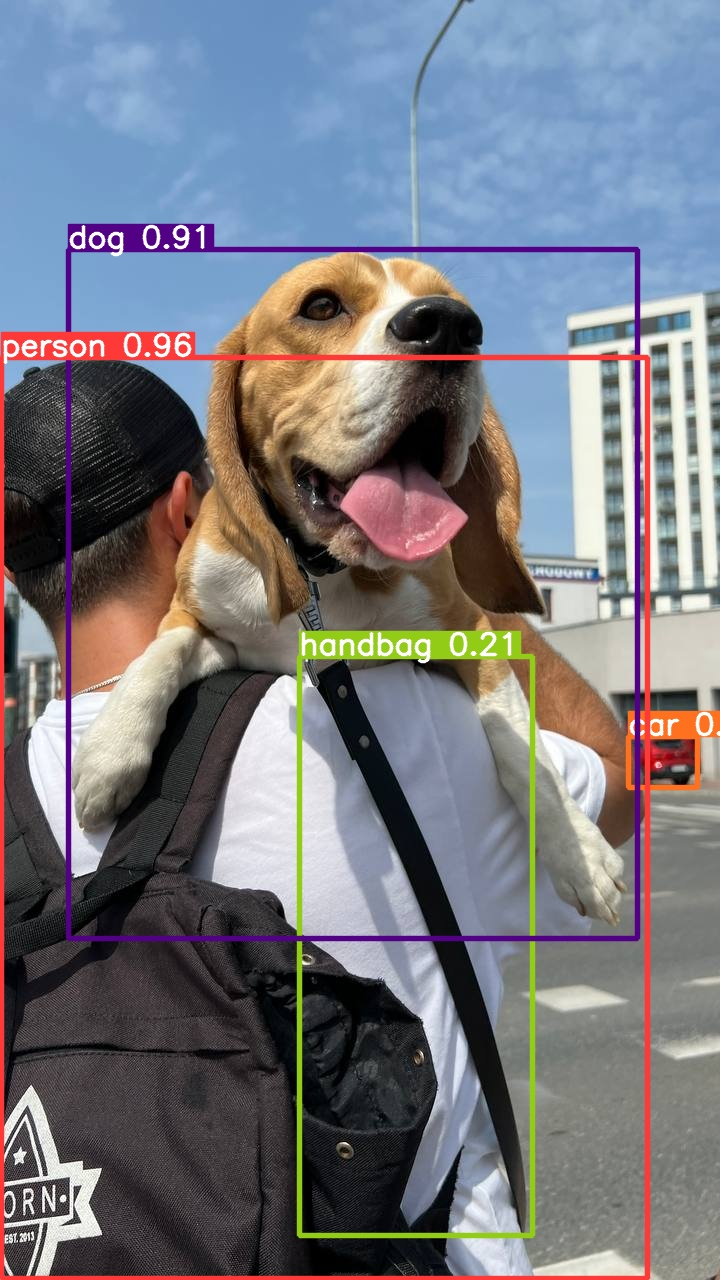

In [12]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/detect/exp/dog.jpeg", width=600)

# gelan-e

In [13]:
!python detect.py --weights {HOME}/weights/gelan-e.pt --conf 0.1 --source {HOME}/data/dog.jpeg --device 0

detect: weights=['/content/weights/gelan-e.pt'], source=/content/data/dog.jpeg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLO 🚀 v0.1-104-g5b1ea9a Python-3.11.13 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)

/content/yolov9/models/experimental.py:243: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weig

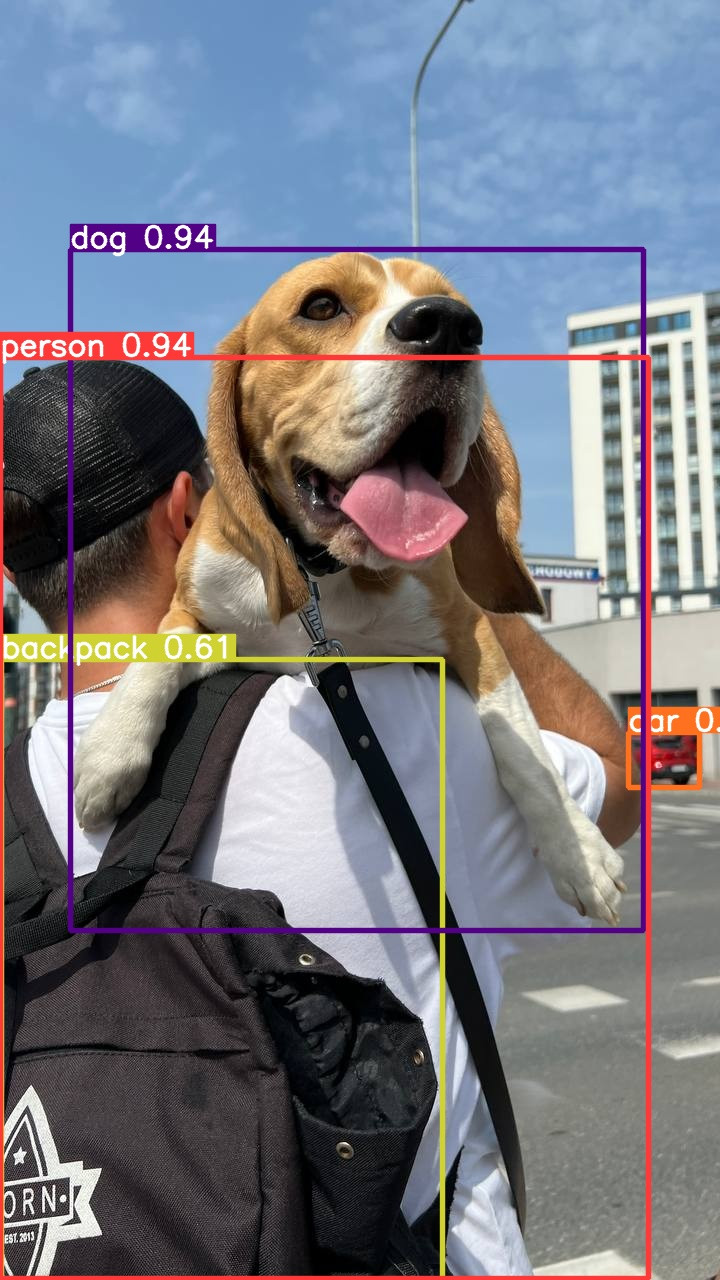

In [14]:
Image(filename=f"{HOME}/yolov9/runs/detect/exp2/dog.jpeg", width=600)

detect.py에 102 열에

pred = pred[0][1] if isinstance(pred[0], list) else pred[0]

삽입


## yolov9-e

In [16]:
!python detect.py --weights {HOME}/weights/yolov9-c.pt --conf 0.1 --source {HOME}/data/dog.jpeg --device 0

detect: weights=['/content/weights/yolov9-c.pt'], source=/content/data/dog.jpeg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLO 🚀 v0.1-104-g5b1ea9a Python-3.11.13 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)

/content/yolov9/models/experimental.py:243: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `wei

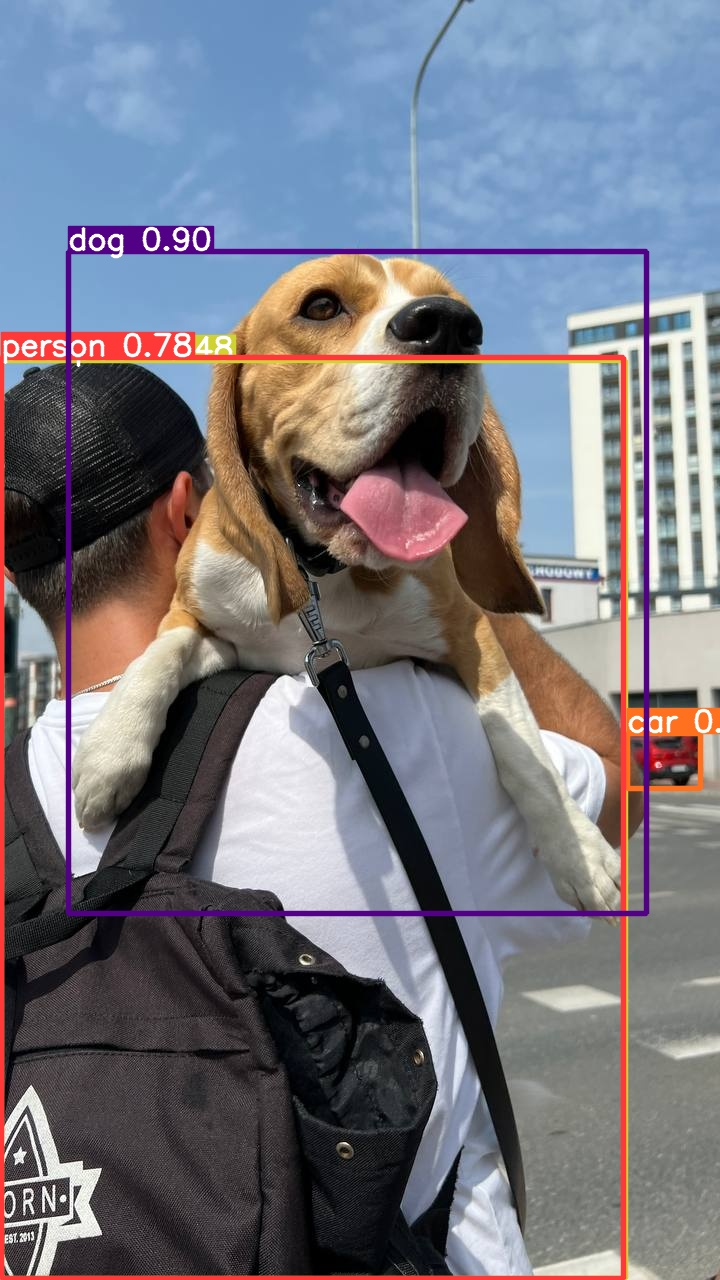

In [17]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/detect/exp4/dog.jpeg", width=600)

# yolov9-e

In [18]:
!python detect.py --weights {HOME}/weights/yolov9-e.pt --conf 0.1 --source {HOME}/data/dog.jpeg --device 0

detect: weights=['/content/weights/yolov9-e.pt'], source=/content/data/dog.jpeg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLO 🚀 v0.1-104-g5b1ea9a Python-3.11.13 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)

/content/yolov9/models/experimental.py:243: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `wei

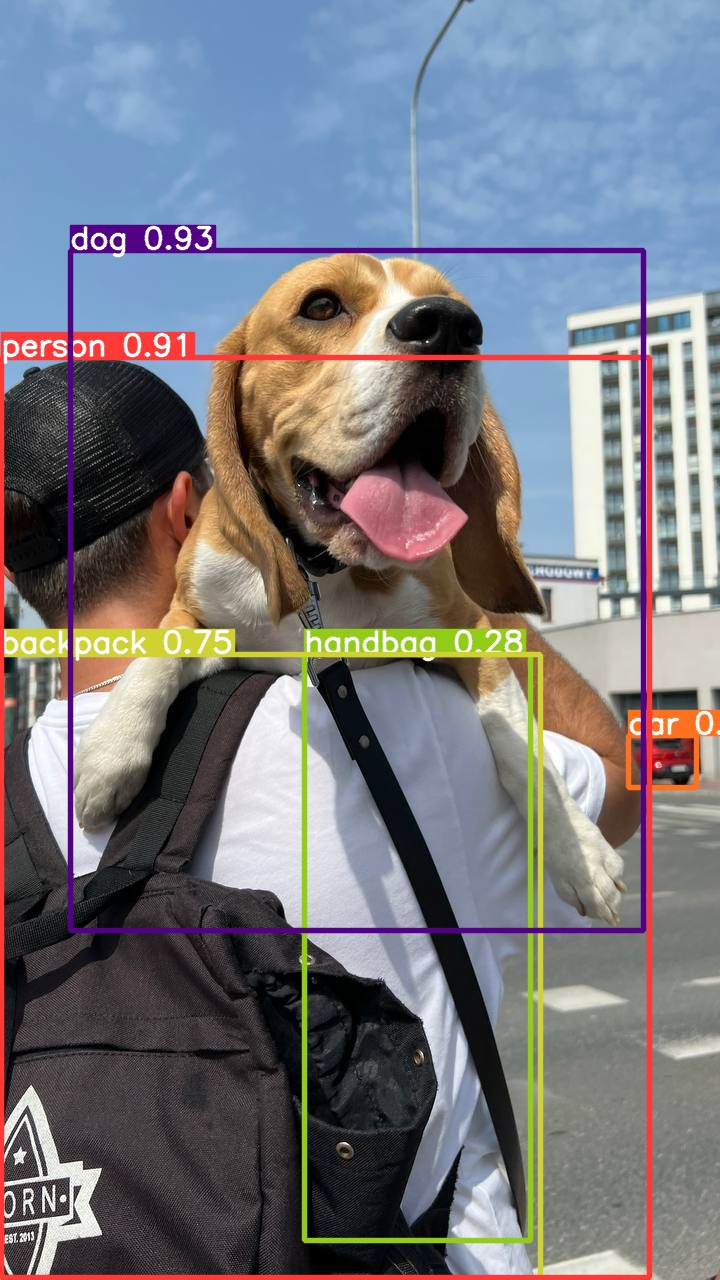

In [19]:

Image(filename=f"{HOME}/yolov9/runs/detect/exp5/dog.jpeg", width=600)

## Authenticate and Download the Dataset

**NOTE:** The dataset must be saved inside the `{HOME}/yolov9` directory, otherwise, the training will not succeed.

In [ ]:
%cd {HOME}/yolov9

/content/yolov9


**NOTE:** In this tutorial, I will use the [football-players-detection](https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc) dataset. Feel free to replace it with your dataset in YOLO format or use another dataset available on [Roboflow Universe](https://universe.roboflow.com). Additionally, if you plan to deploy your model to Roboflow after training, make sure you are the owner of the dataset and that no model is associated with the version of the dataset you are going to training on.

In [21]:
!pip install Pillow==9.5.0

  Using cached Pillow-9.5.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (9.5 kB)
Using cached Pillow-9.5.0-cp311-cp311-manylinux_2_28_x86_64.whl (3.4 MB)
  Attempting uninstall: Pillow
    Found existing installation: pillow 11.2.1
    Uninstalling pillow-11.2.1:
      Successfully uninstalled pillow-11.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pillow-heif 0.22.0 requires pillow>=10.1.0, but you have pillow 9.5.0 which is incompatible.
scikit-image 0.25.2 requires pillow>=10.1, but you have pillow 9.5.0 which is incompatible.


In [6]:
import roboflow
from google.colab import userdata

# Assuming your API key secret is named 'ROBOFLOW_API_KEY'
ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')

rf = roboflow.Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace("roboflow-jvuqo").project("football-players-detection-3zvbc")
version = project.version(8)
dataset = version.download("yolov9")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to football-players-detection-8 in yolov9:: 100%|██████████| 522/522 [00:00<00:00, 3136.63it/s]


In [1]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [2]:
!ls

data  sample_data  weights  yolov9


In [3]:
{HOME}

{'/content'}

In [7]:
{dataset.location}

{'/content/football-players-detection-8'}

In [9]:
# prompt: data.yaml에 path: /content/football-players-detection-8/data.yaml 삽입하기

# Insert 'path: /content/football-players-detection-8/data.yaml' into data.yaml
data_yaml_path = f"{dataset.location}/data.yaml"

with open(data_yaml_path, 'r') as f:
    lines = f.readlines()

with open(data_yaml_path, 'w') as f:
    for line in lines:
        f.write(line)
    # Check if the path is already there to avoid duplicates
    if 'path: /content/football-players-detection-8/data.yaml' not in lines:
        f.write('path: /content/football-players-detection-8/data.yaml\n')

print(f"Inserted path into {data_yaml_path}")
!cat {data_yaml_path}

Inserted path into /content/football-players-detection-8/data.yaml
names:
- ball
- goalkeeper
- player
- referee
nc: 4
roboflow:
  license: CC BY 4.0
  project: football-players-detection-3zvbc
  url: https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc/dataset/8
  version: 8
  workspace: roboflow-jvuqo
test: ../test/images
train: ../train/images
val: ../valid/images
path: /content/football-players-detection-8/data.yaml


## Train Custom Model

In [10]:
%cd {HOME}/yolov9

!python train.py \
--batch 16 --epochs 25 --img 640 --device 0 --min-items 0 --close-mosaic 15 \
--data {dataset.location}/data.yaml \
--weights {HOME}/weights/gelan-c.pt \
--cfg models/detect/gelan-c.yaml \
--hyp hyp.scratch-high.yaml

/content/yolov9
2025-06-23 05:25:59.120238: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750656359.141248   17537 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750656359.147200   17537 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-23 05:25:59.168406: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my 

## Examine Training Results

**NOTE:** By default, the results of each subsequent training sessions are saved in `{HOME}/yolov9/runs/train/`, in directories named `exp`, `exp2`, `exp3`, ... You can override this behavior by using the `--name` parameter.

In [11]:
!ls {HOME}/yolov9/runs/train/exp2/

confusion_matrix.png				     results.csv
events.out.tfevents.1750656392.cd0c99b6dcba.17537.0  results.png
F1_curve.png					     train_batch0.jpg
hyp.yaml					     train_batch1.jpg
labels_correlogram.jpg				     train_batch2.jpg
labels.jpg					     val_batch0_labels.jpg
opt.yaml					     val_batch0_pred.jpg
P_curve.png					     val_batch1_labels.jpg
PR_curve.png					     val_batch1_pred.jpg
R_curve.png					     weights


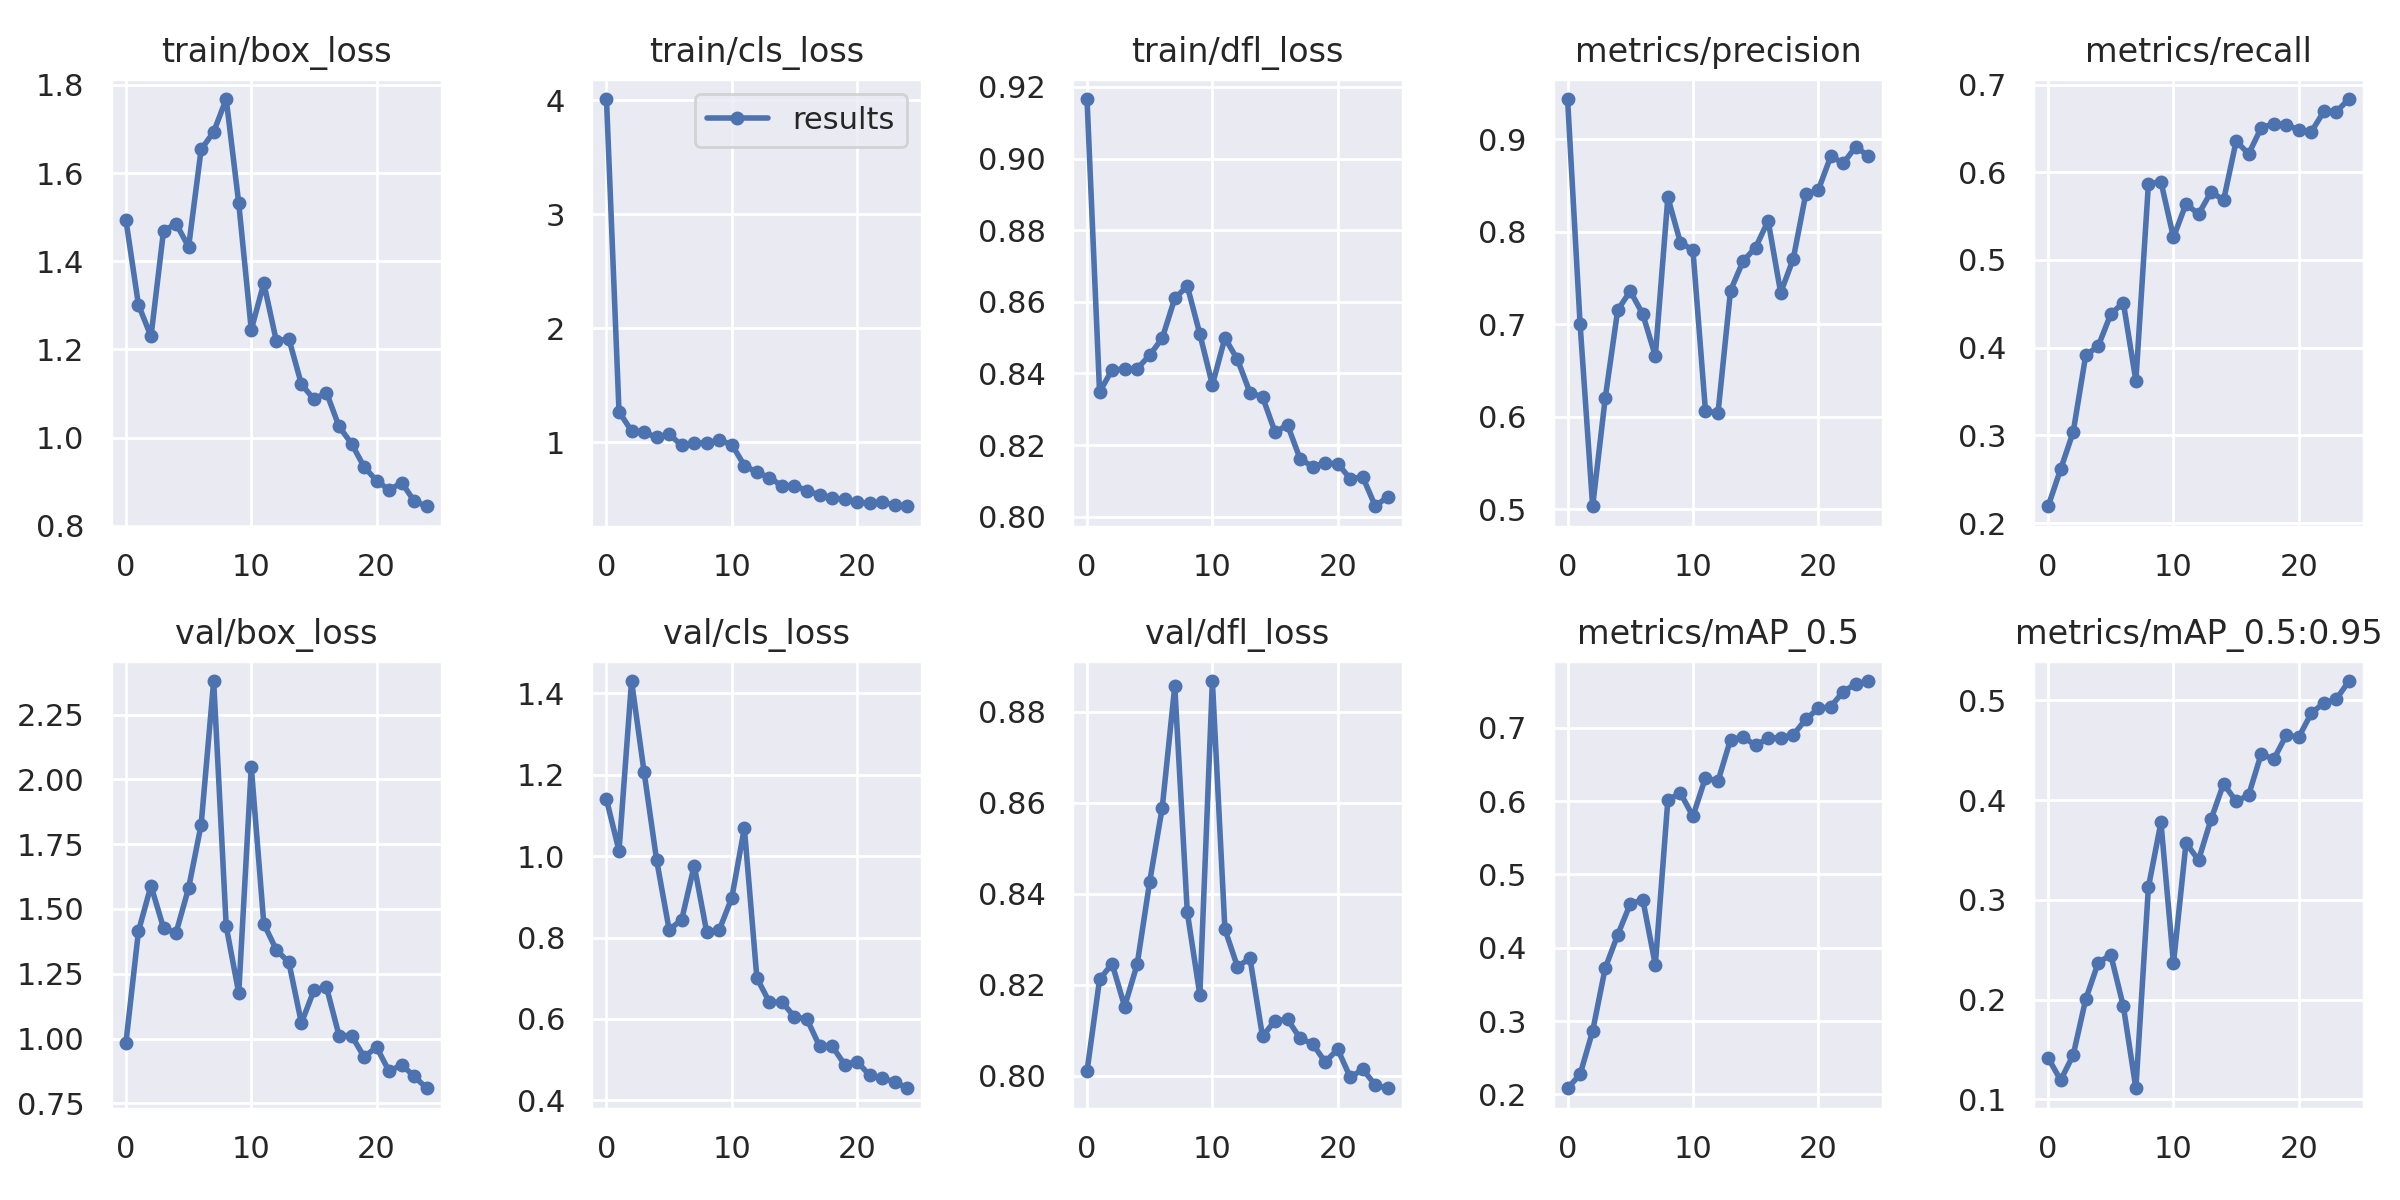

In [12]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp2/results.png", width=1000)

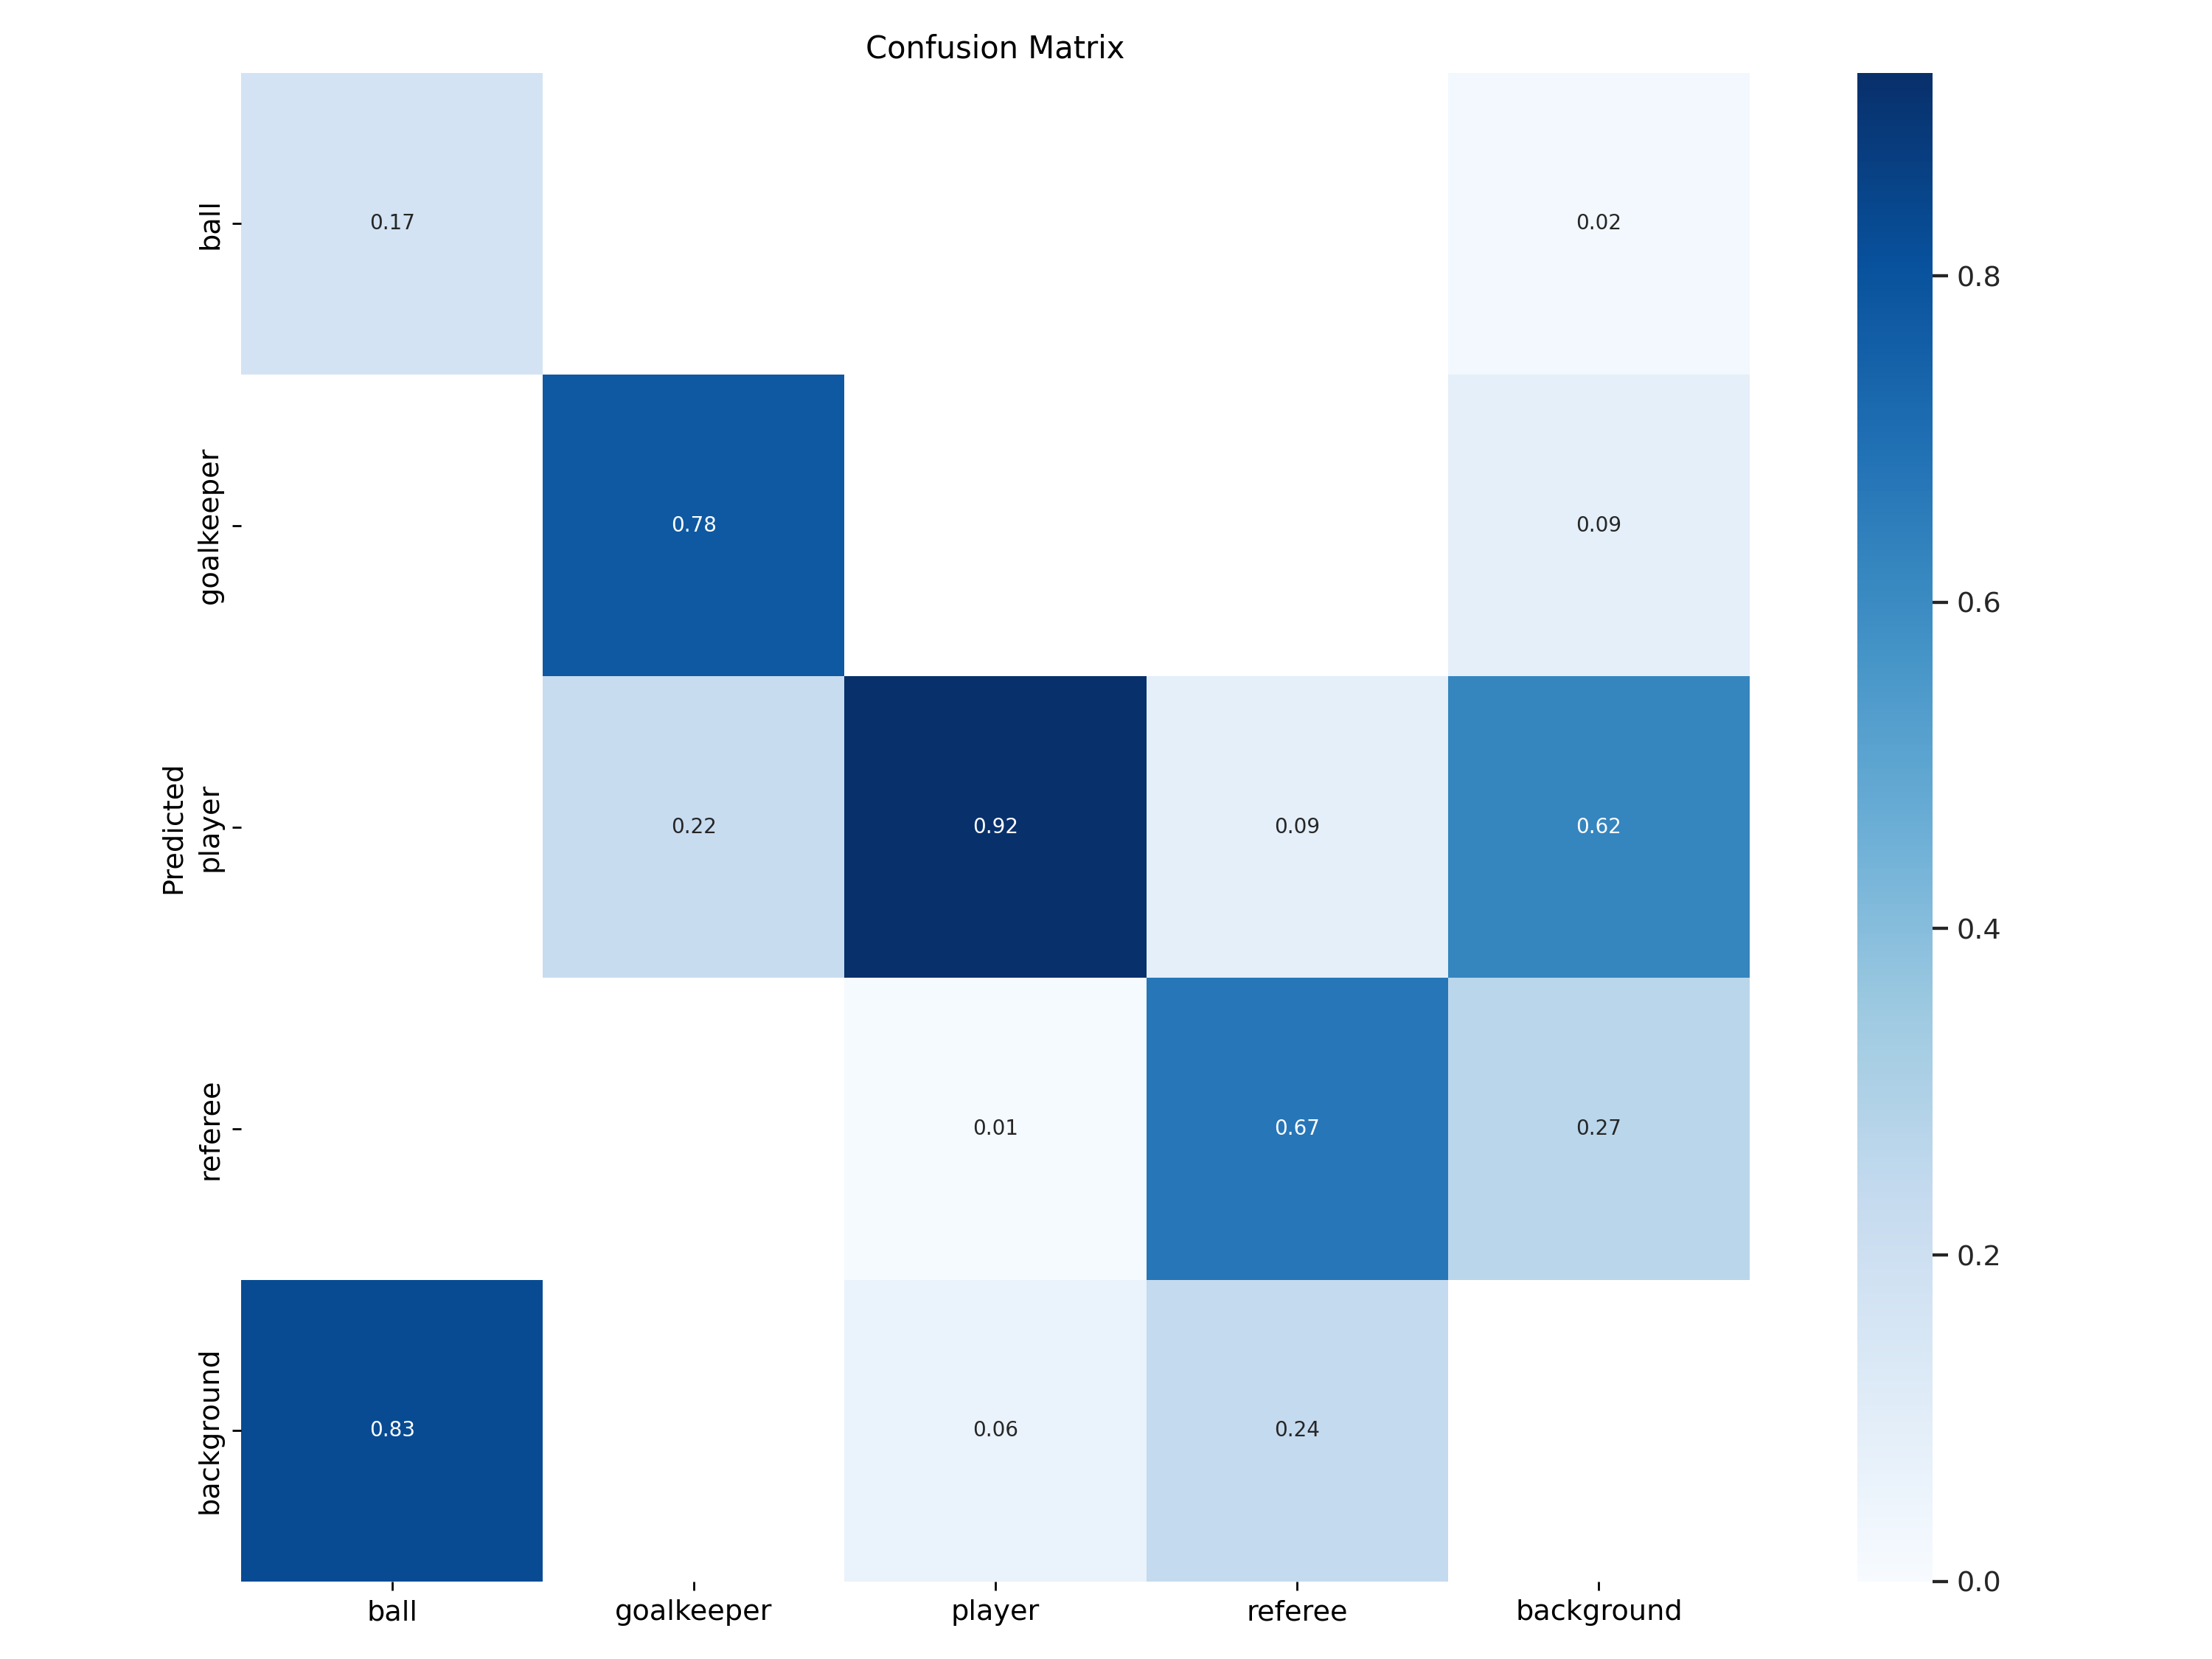

In [14]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp2/confusion_matrix.png", width=1000)

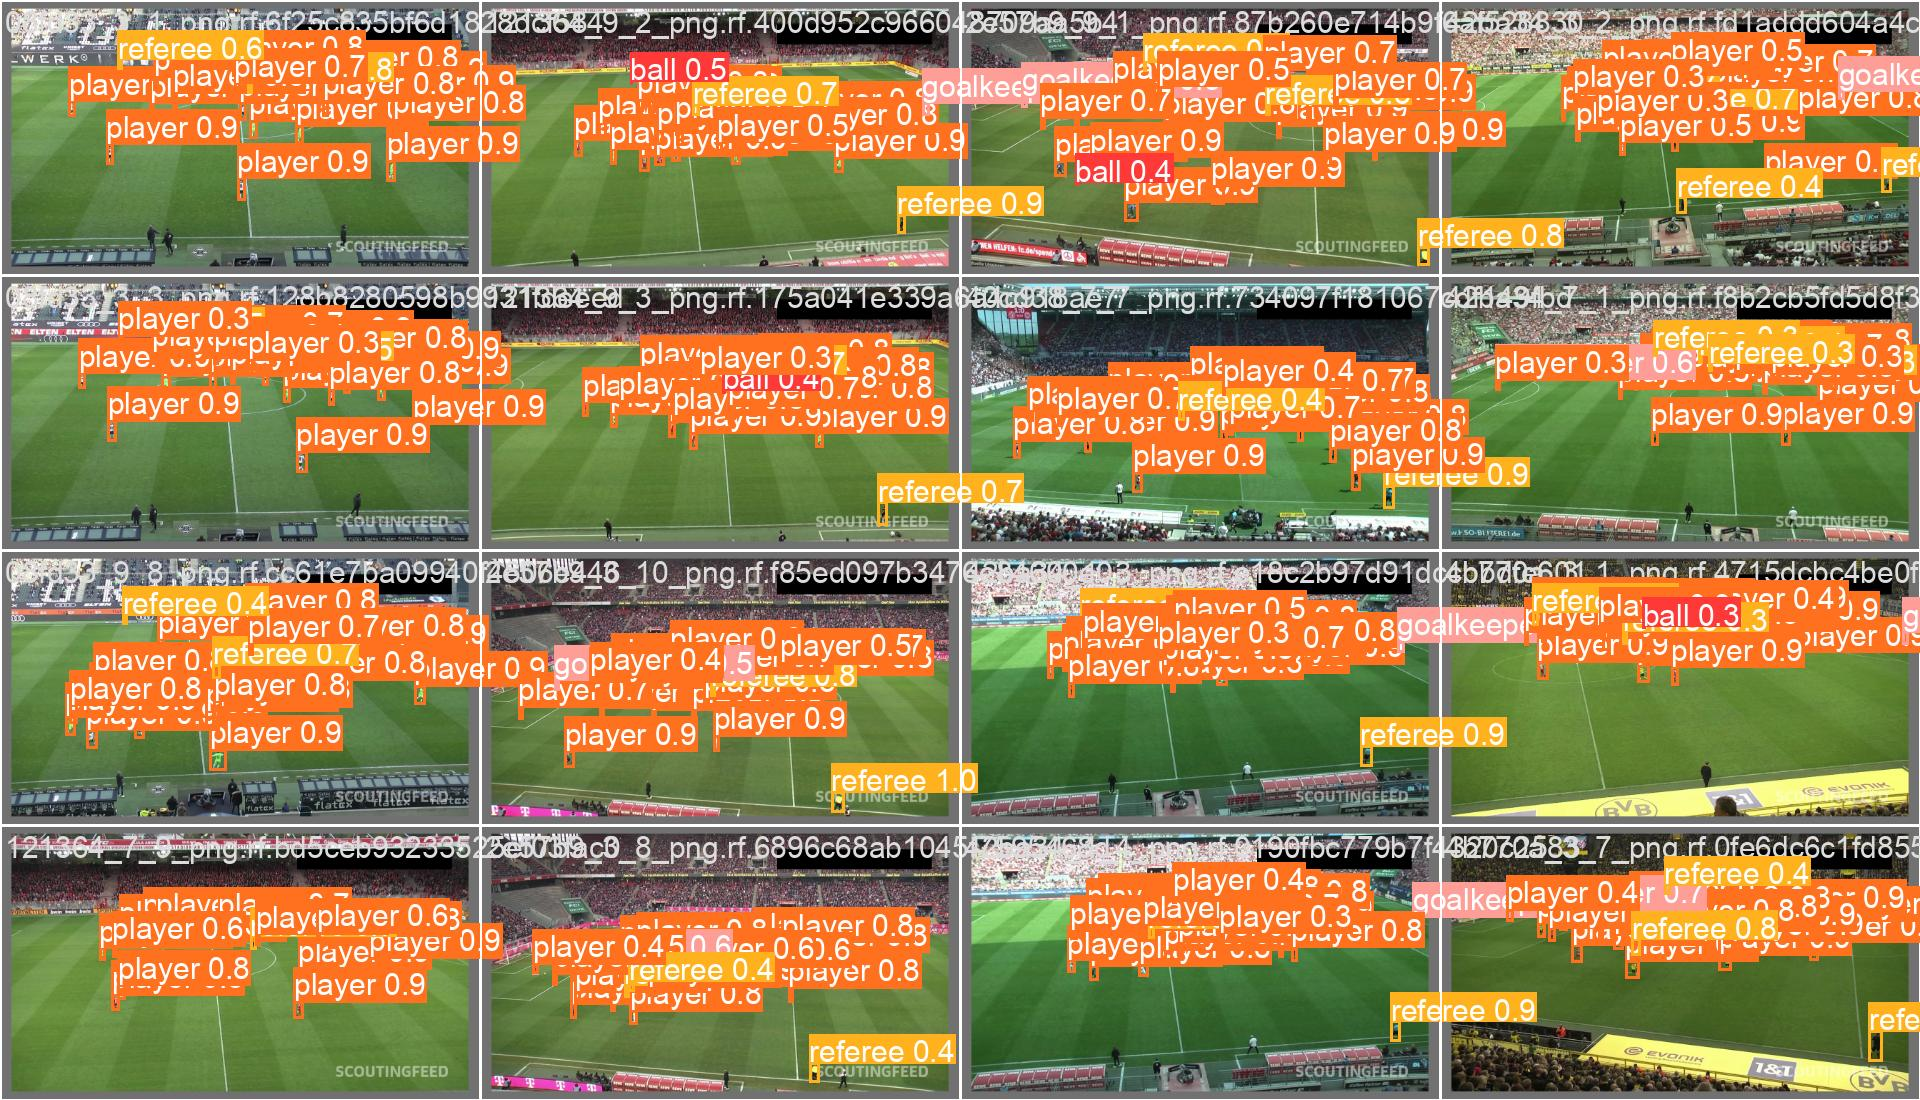

In [15]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp2/val_batch0_pred.jpg", width=1000)

## Validate Custom Model

In [16]:
%cd {HOME}/yolov9

!python val.py \
--img 640 --batch 32 --conf 0.001 --iou 0.7 --device 0 \
--data {dataset.location}/data.yaml \
--weights {HOME}/yolov9/runs/train/exp2/weights/best.pt

/content/yolov9
val: data=/content/football-players-detection-8/data.yaml, weights=['/content/yolov9/runs/train/exp2/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.7, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False, min_items=0
YOLO 🚀 v0.1-104-g5b1ea9a Python-3.11.13 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)

/content/yolov9/models/experimental.py:243: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. Thi

## Inference with Custom Model

In [18]:
!python detect.py \
--img 1280 --conf 0.1 --device 0 \
--weights {HOME}/yolov9/runs/train/exp2/weights/best.pt \
--source {dataset.location}/test/images

detect: weights=['/content/yolov9/runs/train/exp2/weights/best.pt'], source=/content/football-players-detection-8/test/images, data=data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLO 🚀 v0.1-104-g5b1ea9a Python-3.11.13 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)

/content/yolov9/models/experimental.py:243: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details).

**NOTE:** Just like behore, the inference results have been saved in the appropriate directory inside `{HOME}/yolov9/runs/detect/`. Let's examine few of those results.

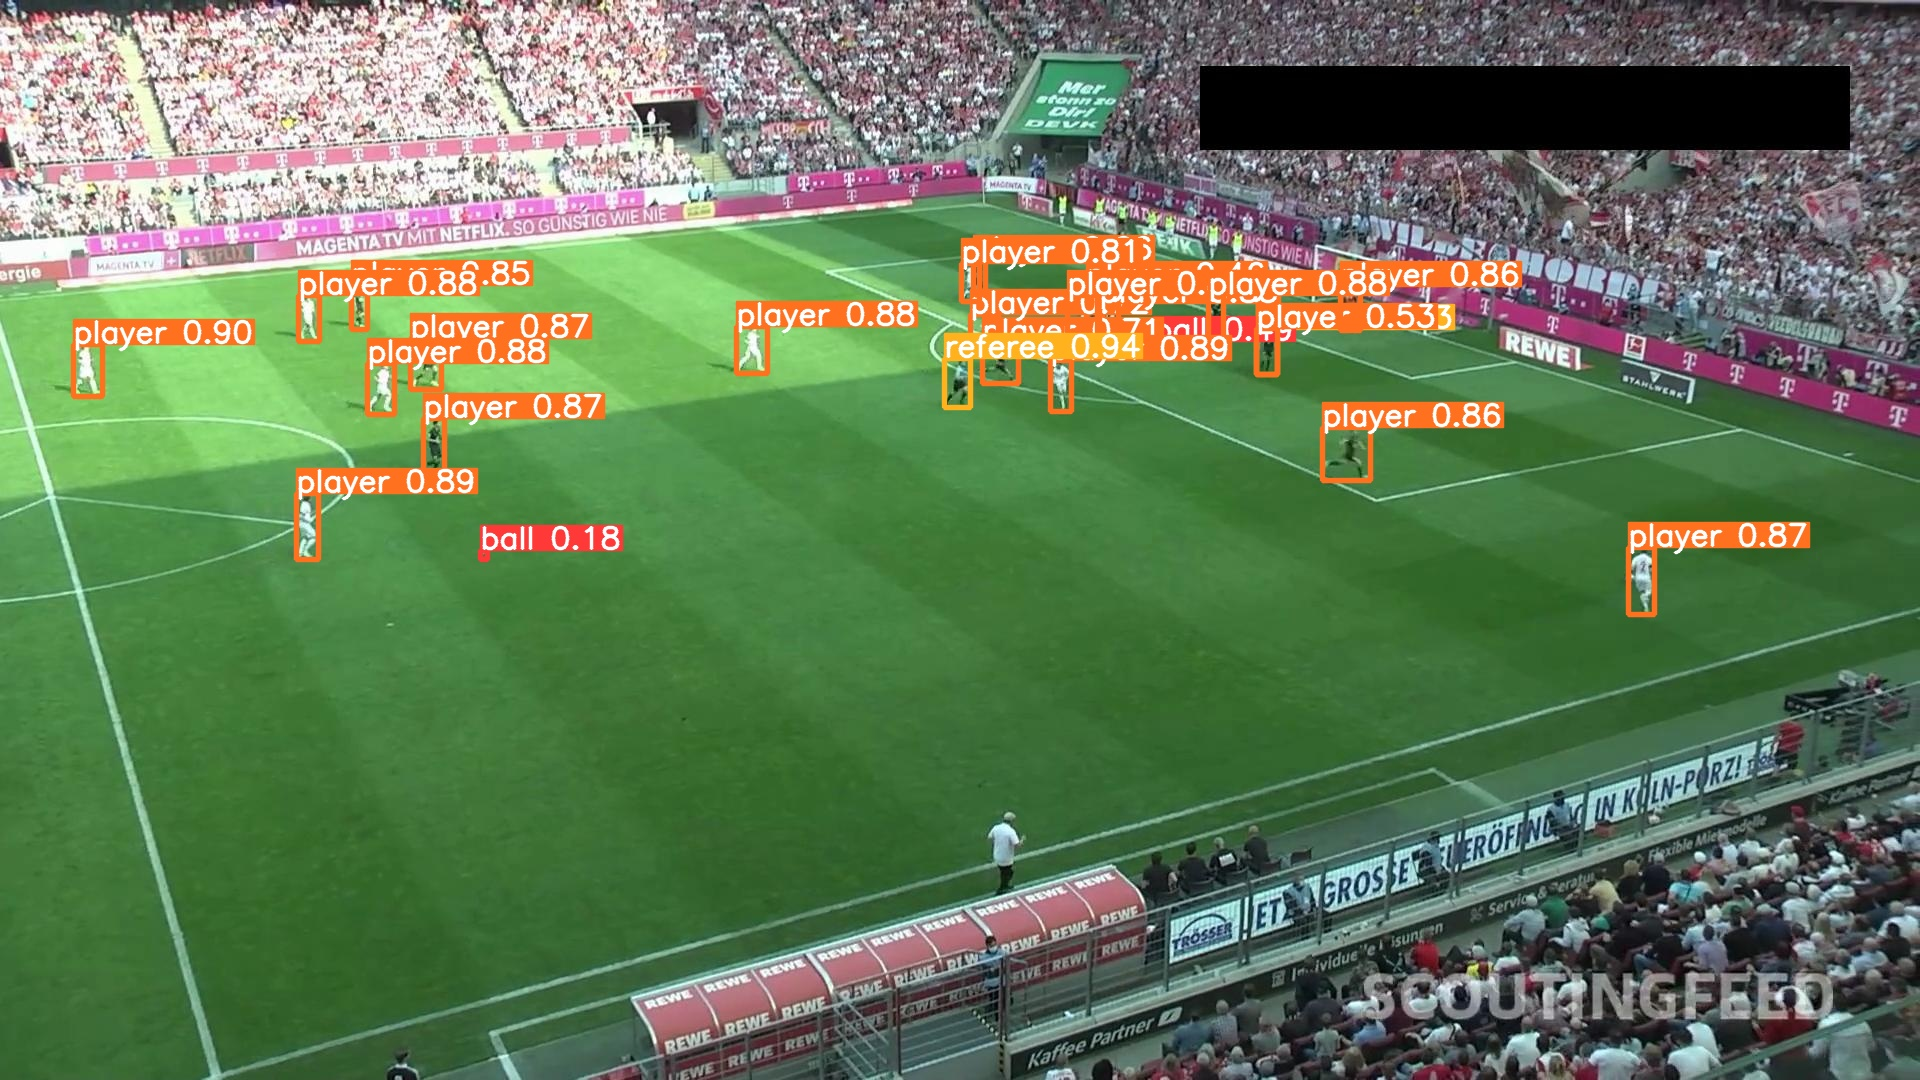

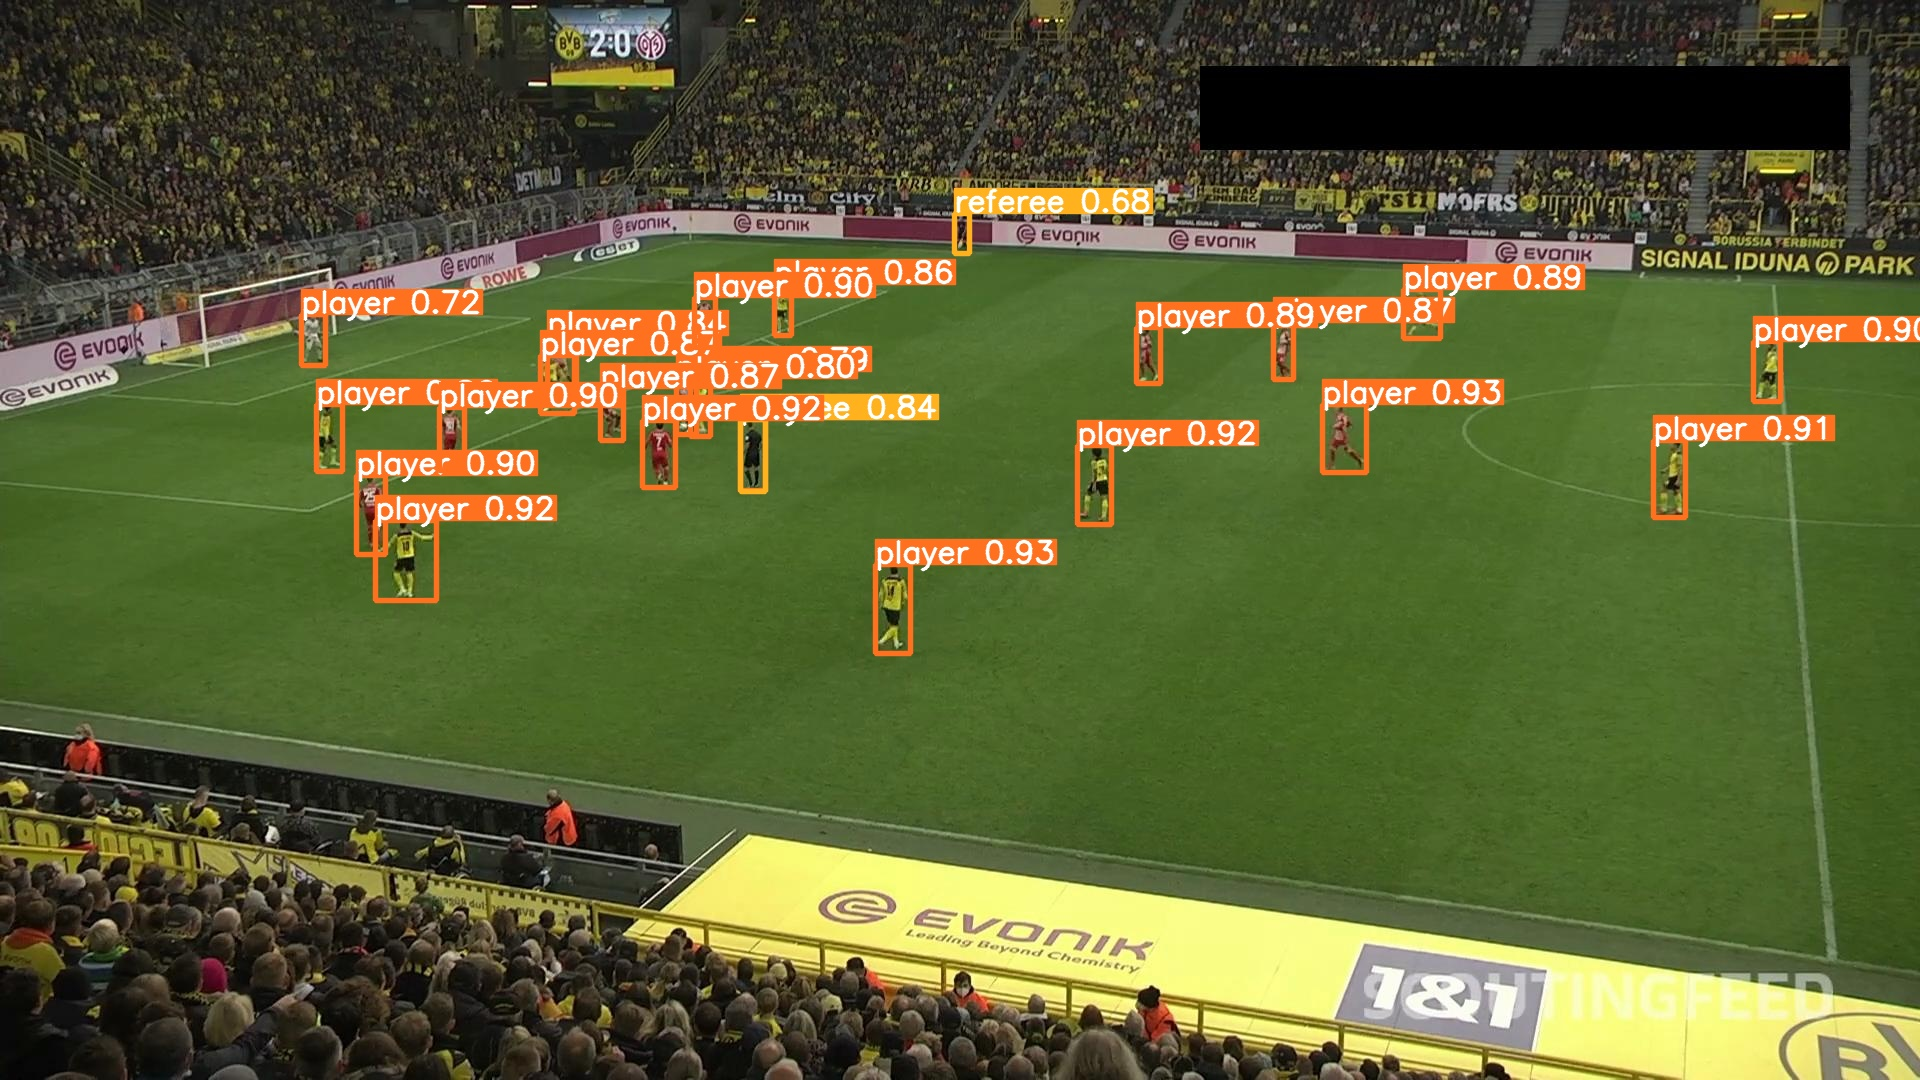

In [19]:
import glob

from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/yolov9/runs/detect/exp6/*.jpg')[:2]:
      display(Image(filename=image_path, width=600))

## BONUS: Deploy YOLOv9 Model with Inference

**NOTE:** To deploy the model and display inference results, we will need two additional packages - [`inference`](https://pypi.org/project/inference) and [`supervision`](https://pypi.org/project/supervision). Let's install and import them!

In [ ]:
!pip install -q inference supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 7.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.1/190.1 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 24.2 MB/s et

In [ ]:
import cv2
import random
import getpass

import supervision as sv

from inference import get_model

%matplotlib inline

ModelDependencyMissing: Your `inference` configuration does not support Qwen2.5-VL model. Use pip install 'inference[transformers]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[sam]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[sam]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[clip]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support Gaze Detection model. Use pip install 'inference[gaze]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support GroundingDINO model. Use pip install 'inference[grounding-dino]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration d

**NOTE:** Before using your model in Inference, you first need to upload your weights to Roboflow Universe. Ensure to specify the correct `model_type` - `yolov9`, and that the project version matches the version of the dataset you used for training, denoted by `[1]`. In my case, it's `6`.

![YOLOv9 Benchmark](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/upload-roboflow-model.png)



In [ ]:
version.deploy(model_type="yolov9", model_path=f"{HOME}/yolov9/runs/train/exp5")

An error occured when getting the model upload URL: 404 Client Error: Not Found for url: https://api.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc/8/uploadModel?api_key=IJBQ2hoCSMbuH5f9iXUs&modelType=yolov9&nocache=true


**NOTE:** Now we can download our model anywhere using the assigned `model_id` denoted by `[2]`. In my case `football-players-detection-3zvbc/6`. To download the model you will need your [`ROBOFLOW_API_KEY`](https://docs.roboflow.com/api-reference/authentication).




In [ ]:
ROBOFLOW_API_KEY = getpass.getpass()

model = get_model(model_id="football-players-detection-3zvbc/8", api_key=ROBOFLOW_API_KEY)

**NOTE:** Let's pick random image from our test subset and detect objects using newly fine-tuned model.

In [ ]:
image_paths = sv.list_files_with_extensions(
    directory=f"{dataset.location}/test/images",
    extensions=['png', 'jpg', 'jpeg']
)
image_path = random.choice(image_paths)
image = cv2.imread(image_path)

result = model.infer(image, confidence=0.1)[0]
detections = sv.Detections.from_inference(result)

**NOTE:** Finally, let's use supervision and [annotate](https://supervision.roboflow.com/develop/annotators/) our results.

In [ ]:
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)
bounding_box_annotator = sv.BoundingBoxAnnotator()

annotated_image = image.copy()
annotated_image = bounding_box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)